# Predict TripAdvisor Rating

The purpose of this notebook is to create a model to predict the TripAdvisor Restaurant rating. 

**Data description:**

- City
- Cuisine Style
- Ranking: rank of the restaurant in comparison with other restaurants in this city
- Price Range
- Number of Reviews
- Reviews: 2 latest reviews
- URL_TA
- ID_TA
- Rating


**Notebook content:**
1. import
2. cleaning and preparing the data
3. EDA
4. Data preprocessing
5. Model
6. Submission

# **1. import**

In [337]:
import numpy as np
import pandas as pd
import ast

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import datetime
from datetime import datetime, timedelta


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [338]:
# fixing RANDOM_SEED and requirements version:
RANDOM_SEED = 42
!pip freeze > requirements.txt

## Data import

In [339]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [340]:
# joining test and train data:
df_train['sample'] = 1 # tagging train data
df_test['sample'] = 0 # tagging test data
df_test['Rating'] = 0 # rating value that we are predicting

data = df_test.append(df_train, sort=False).reset_index(drop=True) # joining

In [341]:
data.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0


In [342]:
# Getting additional data from external sources:
population = {
    'London': 8173900,
    'Paris': 2240621,
    'Madrid': 3155360,
    'Barcelona': 1593075,
    'Berlin': 3326002,
    'Milan': 1331586,
    'Rome': 2870493,
    'Prague': 1272690,
    'Lisbon': 547733,
    'Vienna': 1765649,
    'Amsterdam': 825080,
    'Brussels': 144784,
    'Hamburg': 1718187,
    'Munich': 1364920,
    'Lyon': 496343,
    'Stockholm': 1981263,
    'Budapest': 1744665,
    'Warsaw': 1720398,
    'Dublin': 506211 ,
    'Copenhagen': 1246611,
    'Athens': 3168846,
    'Edinburgh': 476100,
    'Zurich': 402275,
    'Oporto': 221800,
    'Geneva': 196150,
    'Krakow': 756183,
    'Oslo': 673469,
    'Helsinki': 574579,
    'Bratislava': 413192,
    'Luxembourg': 576249,
    'Ljubljana': 277554
}

tourists = {
    'London': 19233000,
    'Paris': 17560200,
    'Madrid': 5440100 ,
    'Barcelona': 6714500,
    'Berlin': 5959400,
    'Milan': 6481300,
    'Rome': 10065400,
    'Prague': 8948600,
    'Lisbon':  3539400,
    'Vienna': 6410300,
    'Amsterdam': 8354200,
    'Brussels': 3942000,
    'Hamburg': 1450000,
    'Munich': 4066600,
    'Lyon': 3090000,
    'Stockholm': 2604600,
    'Budapest': 3822800,
    'Warsaw': 2850000,
    'Dublin': 5213400,
    'Copenhagen': 3069700,
    'Athens': 5728400,
    'Edinburgh': 1660000,
    'Zurich': 2240000,
    'Oporto': 2341300,
    'Geneva': 1150000,
    'Krakow': 2732000,
    'Oslo': 1000000,
    'Helsinki': 947772,
    'Bratislava': 916949,
    'Luxembourg': 1139000,
    'Ljubljana': 851305
}

is_capital = {
    'London': True,
    'Paris': True,
    'Madrid': True,
    'Barcelona': False,
    'Berlin': True,
    'Milan': False,
    'Rome': True,
    'Prague': True,
    'Lisbon': True,
    'Vienna': True,
    'Amsterdam': True,
    'Brussels': True,
    'Hamburg': False,
    'Munich': False,
    'Lyon': False,
    'Stockholm': True,
    'Budapest': True,
    'Warsaw': True,
    'Dublin': True,
    'Copenhagen': True,
    'Athens': True,
    'Edinburgh': True,
    'Zurich': True,
    'Oporto': False,
    'Geneva': True,
    'Krakow': True,
    'Oslo': True,
    'Helsinki': True,
    'Bratislava': True,
    'Luxembourg': True,
    'Ljubljana': True
}

## number of restaurants per city
restaurant_per_city = data['City'].value_counts(ascending=False)
data['rest_counts'] = data['City'].apply(lambda x: restaurant_per_city[x])

# 2. Cleaning and Preparing Data 

## 2.1 Cleaning NAN

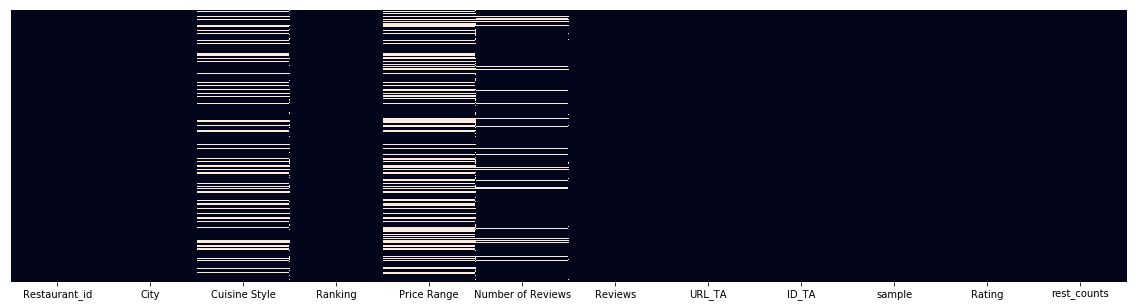

In [343]:
# checking which columns have missing values
fig, ax = plt.subplots(figsize=(20, 5))
sns_heatmap = sns.heatmap(
    data.isnull(), yticklabels=False, cbar=False)

In [344]:
# cleaning columns Cuisine Style, Price Range, Number of reviews:
data['Number of Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')
data['Cuisine Style_isNAN'] = pd.isna(data['Cuisine Style']).astype('uint8')
data['Price Range_isNAN'] = pd.isna(data['Price Range']).astype('uint8')
data['Reviews_isNAN'] = pd.isna(data['Reviews']).astype('uint8')

## 2.2 Restaurant identification

In [345]:
# Let´s check which parameters  could uniquely identify the restaurant (Restaurant_id, URL_TA, ID_TA).
# Based on the data source content generation, we know that there might be multiple entries for each restaurant
# Restaurant_id does not give us a unique way to identify a restaurant, it seems to be a random value, that we should exclude.
data[data.Restaurant_id == "id_633"].head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,rest_counts,Number of Reviews_isNAN,Cuisine Style_isNAN,Price Range_isNAN,Reviews_isNAN
633,id_633,Stockholm,['Indian'],1261.0,NaN,9.0,"[['One more Indian Restaurant', 'Tiny and nice...",/Restaurant_Review-g189852-d8341999-Reviews-Fo...,d8341999,0,0.0,1033,0,0,1,0
10836,id_633,Milan,"['Italian', 'Pizza', 'Mediterranean', 'Vegetar...",635.0,$$ - $$$,743.0,[['Sunshine of Italian pizza in Milan on a we....,/Restaurant_Review-g187849-d7660183-Reviews-Br...,d7660183,1,3.5,2694,0,0,0,0
12927,id_633,Budapest,['Vegetarian Friendly'],634.0,$,18.0,"[['Good qualitybreakfast and lovely venue', 'G...",/Restaurant_Review-g274887-d12327467-Reviews-F...,d12327467,1,4.5,1021,0,0,0,0
14359,id_633,Rome,"['Italian', 'Pizza', 'Fast Food', 'Mediterrane...",634.0,$,600.0,"[['Cheap, delicious, good service, quick', 'Gr...",/Restaurant_Review-g187791-d3190881-Reviews-Re...,d3190881,1,4.5,2589,0,0,0,0
14864,id_633,Munich,"['Peruvian', 'Latin', 'South American', 'Veget...",640.0,$$ - $$$,173.0,"[['Very good but service', 'Nice!'], ['05/13/2...",/Restaurant_Review-g187309-d1674728-Reviews-Na...,d1674728,1,4.0,1145,0,0,0,0


In [346]:
(data['URL_TA'].value_counts() == 2).count()

49963

In [347]:
# URL_TA, although has duplicates, seems to deliver a better identification of a restaurant
data[data.URL_TA == "/Restaurant_Review-g187514-d4914988-Reviews-Xiang_Asia_Restaurant-Madrid.html"]

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,rest_counts,Number of Reviews_isNAN,Cuisine Style_isNAN,Price Range_isNAN,Reviews_isNAN
2654,id_2654,Madrid,"['Chinese', 'Japanese', 'Asian']",3146.0,$$ - $$$,53.0,"[['Excellent food food', 'Fantastic sushi serv...",/Restaurant_Review-g187514-d4914988-Reviews-Xi...,d4914988,0,0.0,3813,0,0,0,0
39640,id_3302,Madrid,"['Chinese', 'Japanese', 'Asian']",3304.0,$$ - $$$,53.0,"[['Excellent food food', 'Fantastic sushi serv...",/Restaurant_Review-g187514-d4914988-Reviews-Xi...,d4914988,1,4.0,3813,0,0,0,0


In [348]:
data["ID_TA"].value_counts()

d11999956    2
d2360290     2
d2477531     2
d4748208     2
d1568045     2
            ..
d12184366    1
d1024837     1
d13187202    1
d7378446     1
d6437529     1
Name: ID_TA, Length: 49963, dtype: int64

In [349]:
data[data.ID_TA == "d697406"]

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,rest_counts,Number of Reviews_isNAN,Cuisine Style_isNAN,Price Range_isNAN,Reviews_isNAN
14578,id_1180,Madrid,"['Moroccan', 'Vegetarian Friendly', 'Vegan Opt...",1181.0,$$ - $$$,341.0,"[['Great food, service and atmosphere', 'Decor...",/Restaurant_Review-g187514-d697406-Reviews-Al_...,d697406,1,4.0,3813,0,0,0,0
38096,id_1209,Madrid,"['Moroccan', 'Vegetarian Friendly', 'Vegan Opt...",1210.0,$$ - $$$,341.0,"[['Great food, service and atmosphere', 'Decor...",/Restaurant_Review-g187514-d697406-Reviews-Al_...,d697406,1,4.0,3813,0,0,0,0


In [350]:
# we should use "ID_TA" as unique identifier of a restaurant

## 2.3 Target variable

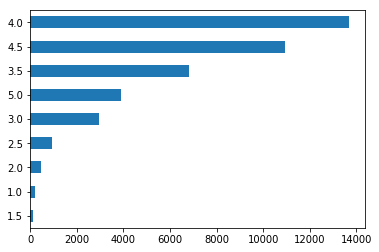

In [351]:
# We want to predict the Rating variable. Let´s see it´s distribution and how it is correlated to the other variables that are in the data set.
# Most of the restaurant are between 4.0 and 4.5 Rating values
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

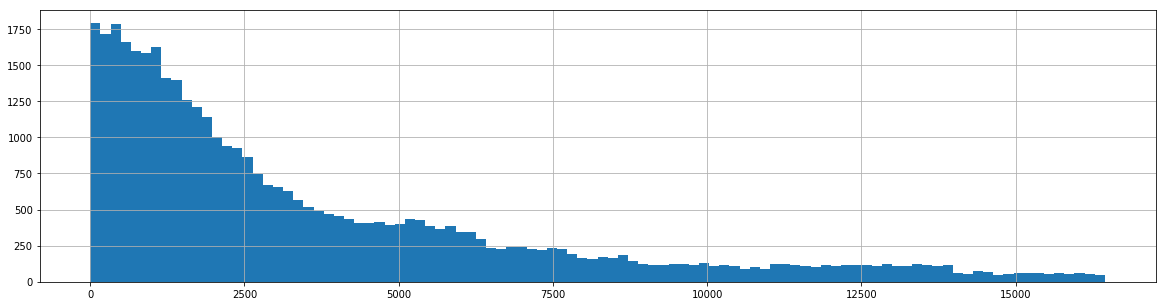

In [352]:
# At the same time, there is Ranking variable, which shows the Rank of a restaurant within a given city
# There are a lot of the restaurants which have Rank between 9 and 1000, meaning that not all cities have more than 1000 restaurants
plt.rcParams['figure.figsize'] = (20,5)
df_train['Ranking'].hist(bins=100)

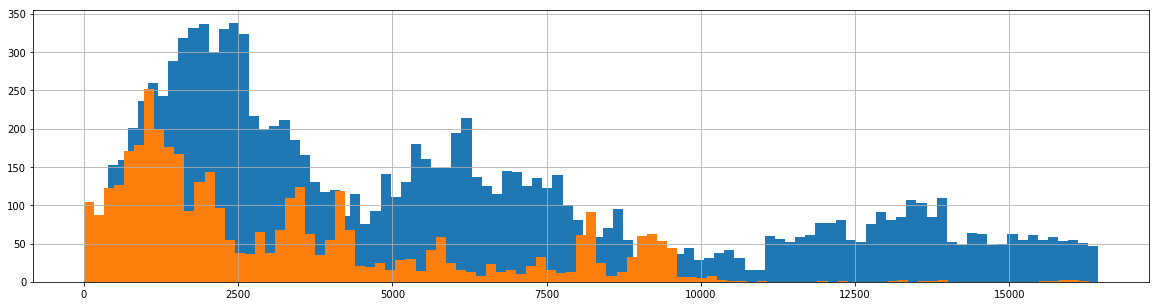

In [353]:
# Rating is quite randomly distributed within different Ranking values
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

# 2.4 Other variables in the data set

## 2.1 Ranking

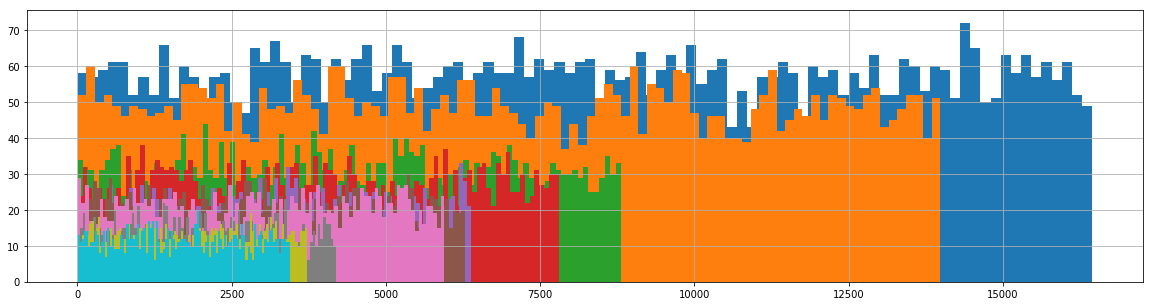

In [354]:
# looking at the distribution of Ranking among top 10 cities, we need to normalize it based on how many restaurants there are in a city
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

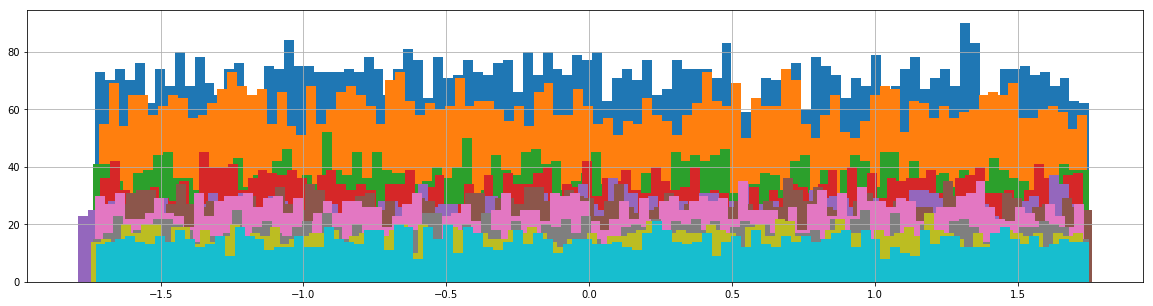

In [355]:
# Normalizing the ranking
data['ranking_normalized'] = data.groupby('City')['Ranking'].transform(lambda x: (x-x.mean())/x.std())
for x in (data['City'].value_counts())[0:10].index:
    data['ranking_normalized'][data['City'] == x].hist(bins=100)
plt.show()

In [356]:
# Creating the Relative ranking, which shows the rank of the restaurant in context of how many restuarants there are
data['ranking_relative'] = data['Ranking'] / data['rest_counts']

## 2.2 City

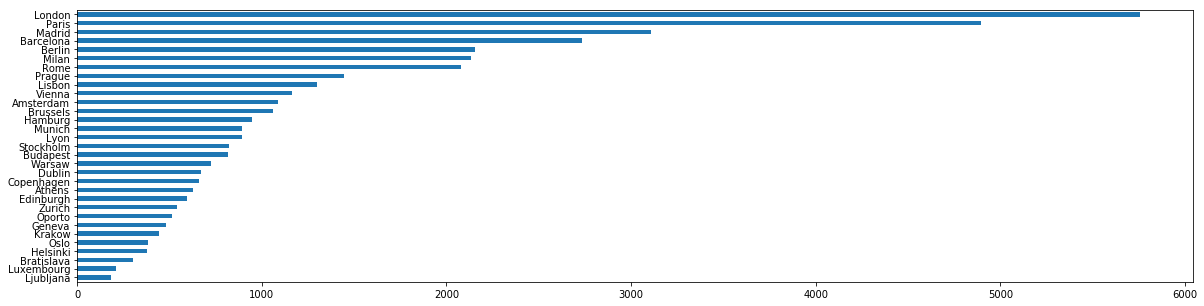

In [357]:
# Checking distribution of restaurants by cities
df_train['City'].value_counts(ascending=True).plot(kind='barh')

In [358]:
# Getting additional parameters in the data set:


## restaurant density per population
data['population'] = data['City'].map(population)
data['rest_density'] = data['rest_counts'] / data['population']

## restaurant density per tourists
data['tourists'] = data['City'].map(tourists)
data['rest_per_tourist'] = data['rest_counts'] / data['tourists']

## indication whether it is a capital
data['is_capital'] = data['City'].map(is_capital)



In [359]:
# using One-Hot Encoding to get dummy columns
data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)

## 2.3 Cuisine Style

In [360]:
# Processing Cuisine Style parameter, calculating number of cuisines
data['cuisine_style'] = data['Cuisine Style'].str[2:-2].str.split("', '")
data['cuisine_style'] = data['Cuisine Style'].fillna("['Other']")
data['cuisine_num'] = data['Cuisine Style'].str.len()

## 2.4 Price Range

In [361]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

In [362]:
# The most common Price Range is $$-$$$, so we will fill in the blanks with this value
new_price_range = {'Price Range':     {"$": 1, "$$ - $$$": 100, "$$$$": 1000, np.NaN: 100}}
data['Price Range NAN'] = data['Price Range'].isna()
data.replace(new_price_range, inplace=True)

## 2.5 Reviews

In [363]:
# Filling in empty values in Number of Reviews
data['Number of Reviews'] = data['Number of Reviews'].fillna(0)

In [364]:
# Creating date parameters for Reviews date, filling in with the earliest the empty rows
data['Reviews'] = data['Reviews'].fillna(0)
reviews_date = []
for i in data['Reviews']:
    if i == '[[], []]' or i == 0:
        reviews_date.append('')
    else:
        i = str(i).replace(']]', '')
        i = i.replace("'", '')
        i = i.split('], [')[1]
        i = i.split(', ')
        reviews_date.append(i)

data['reviews_date'] = reviews_date      
        
data['reviews_date_1'] = data['reviews_date'].apply(lambda x: x[1] if len(x) == 2 else None)
data['reviews_date_2'] = data['reviews_date'].apply(lambda x: x[0] if len(x) > 0 else None)

data['reviews_date_1'] = pd.to_datetime(data['reviews_date_1'])
data['reviews_date_2'] = pd.to_datetime(data['reviews_date_2'])

data['reviews_date_1'] = data['reviews_date_1'].apply(lambda x: data['reviews_date_1'].min()\
                                                      if pd.isnull(x) else x)
data['reviews_date_2'] = data['reviews_date_2'].apply(lambda x: data['reviews_date_1'].min()\
                                                      if pd.isnull(x) else x)

In [365]:
# Counting number of days between reviews
data['between_dates'] = (data['reviews_date_2'] - data['reviews_date_1']).dt.days

In [366]:
# Counting number of days since last review
data['days_to_today'] = (datetime.now() - data['reviews_date_2']).dt.days

## 2.6 Correlation matrix

In [367]:
data.head()

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Zurich,City_nan,cuisine_style,cuisine_num,Price Range NAN,reviews_date,reviews_date_1,reviews_date_2,between_dates,days_to_today
0,id_0,"['Bar', 'Pub']",12963.0,100,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,0,"['Bar', 'Pub']",14.0,False,,2007-11-14,2007-11-14,0,4781
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,100,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,0,"['European', 'Scandinavian', 'Gluten Free Opti...",91.0,False,"[12/05/2017, 10/29/2017]",2017-10-29,2017-12-05,37,1107
2,id_2,['Vegetarian Friendly'],810.0,100,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,0,['Vegetarian Friendly'],23.0,False,"[12/28/2017, 12/06/2017]",2017-12-06,2017-12-28,22,1084
3,id_3,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,1000,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,0,"['Italian', 'Mediterranean', 'European', 'Vege...",86.0,False,"[12/06/2017, 11/22/2017]",2017-11-22,2017-12-06,14,1106
4,id_4,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,1000,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,0,"['Italian', 'Mediterranean', 'European', 'Seaf...",97.0,False,"[02/08/2018, 01/24/2018]",2018-01-24,2018-02-08,15,1042


In [368]:
data = data.drop(['Restaurant_id', 
                  'Cuisine Style', 
                  'Price Range', 
                  'cuisine_style', 
                  'reviews_date',
                  'reviews_date_1',
                  'reviews_date_2',
                  'Reviews', 
                  'URL_TA', 
                  'ID_TA',
                  'ranking_relative',
                  'cuisine_num'
                 ], 
                 axis = 1)
data

,Ranking,Number of Reviews,sample,Rating,rest_counts,Number of Reviews_isNAN,Cuisine Style_isNAN,Price Range_isNAN,Reviews_isNAN,ranking_normalized,...,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,Price Range NAN,between_dates,days_to_today
0,12963.0,4.0,0,0.0,6108,0,0,0,0,1.491224,...,0,0,0,0,0,0,0,False,0,4781
1,106.0,97.0,0,0.0,475,0,0,0,0,-1.404530,...,0,0,0,0,0,0,0,False,37,1107
2,810.0,28.0,0,0.0,745,0,0,0,0,-0.146058,...,0,0,0,0,0,0,0,False,22,1084
3,1669.0,202.0,0,0.0,7193,0,0,0,0,-1.376113,...,0,0,0,0,0,0,0,False,14,1106
4,37.0,162.0,0,0.0,380,0,0,0,0,-1.673120,...,0,0,0,0,0,0,0,False,15,1042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,500.0,79.0,1,4.5,2694,0,0,0,0,-1.448276,...,0,0,0,0,0,0,0,False,34,1096
49996,6341.0,542.0,1,3.5,6108,0,0,0,0,-0.147913,...,0,0,0,0,0,0,0,False,9,1091
49997,1652.0,4.0,1,4.5,1033,0,0,1,0,0.573818,...,0,0,1,0,0,0,0,True,3127,1504
49998,641.0,70.0,1,4.0,925,0,0,0,0,-0.663243,...,0,0,0,0,1,0,0,False,23,1254


In [369]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 50 columns):
Ranking                    50000 non-null float64
Number of Reviews          50000 non-null float64
sample                     50000 non-null int64
Rating                     50000 non-null float64
rest_counts                50000 non-null int64
Number of Reviews_isNAN    50000 non-null uint8
Cuisine Style_isNAN        50000 non-null uint8
Price Range_isNAN          50000 non-null uint8
Reviews_isNAN              50000 non-null uint8
ranking_normalized         50000 non-null float64
population                 50000 non-null int64
rest_density               50000 non-null float64
tourists                   50000 non-null int64
rest_per_tourist           50000 non-null float64
is_capital                 50000 non-null bool
City_Amsterdam             50000 non-null uint8
City_Athens                50000 non-null uint8
City_Barcelona             50000 non-null uint8
City_Berlin     

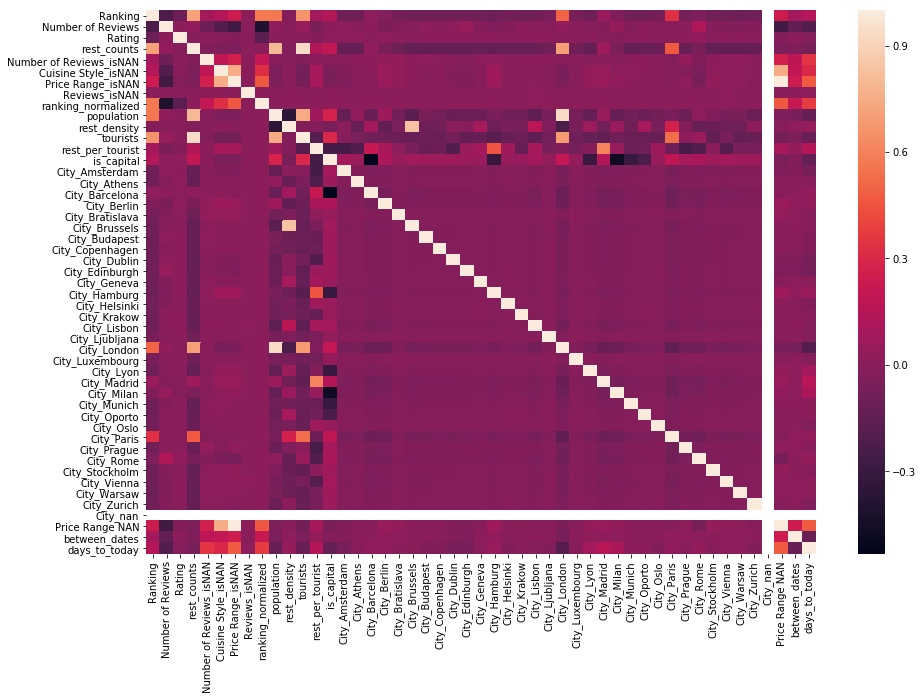

In [370]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

In [371]:
# Separating the train and test parts
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values
X = train_data.drop(['Rating'], axis=1)

In [372]:
train_data

,Ranking,Number of Reviews,Rating,rest_counts,Number of Reviews_isNAN,Cuisine Style_isNAN,Price Range_isNAN,Reviews_isNAN,ranking_normalized,population,...,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,Price Range NAN,between_dates,days_to_today
10000,5570.0,194.0,3.5,6108,0,0,0,0,-0.338757,2240621,...,0,0,0,0,0,0,0,False,41,1081
10001,1537.0,10.0,4.0,1033,0,1,1,0,0.414623,1981263,...,0,0,1,0,0,0,0,True,382,1259
10002,353.0,688.0,4.5,7193,0,0,0,0,-1.654692,8173900,...,0,0,0,0,0,0,0,False,2,1073
10003,3458.0,3.0,5.0,2705,0,1,1,0,0.111518,3326002,...,0,0,0,0,0,0,0,True,0,4781
10004,621.0,84.0,4.0,1145,0,0,0,0,-0.930648,1364920,...,0,0,0,0,0,0,0,False,272,1124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,500.0,79.0,4.5,2694,0,0,0,0,-1.448276,1331586,...,0,0,0,0,0,0,0,False,34,1096
49996,6341.0,542.0,3.5,6108,0,0,0,0,-0.147913,2240621,...,0,0,0,0,0,0,0,False,9,1091
49997,1652.0,4.0,4.5,1033,0,0,1,0,0.573818,1981263,...,0,0,1,0,0,0,0,True,3127,1504
49998,641.0,70.0,4.0,925,0,0,0,0,-0.663243,1720398,...,0,0,0,0,1,0,0,False,23,1254


In [373]:
test_data

,Ranking,Number of Reviews,Rating,rest_counts,Number of Reviews_isNAN,Cuisine Style_isNAN,Price Range_isNAN,Reviews_isNAN,ranking_normalized,population,...,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,Price Range NAN,between_dates,days_to_today
0,12963.0,4.0,0.0,6108,0,0,0,0,1.491224,2240621,...,0,0,0,0,0,0,0,False,0,4781
1,106.0,97.0,0.0,475,0,0,0,0,-1.404530,574579,...,0,0,0,0,0,0,0,False,37,1107
2,810.0,28.0,0.0,745,0,0,0,0,-0.146058,476100,...,0,0,0,0,0,0,0,False,22,1084
3,1669.0,202.0,0.0,7193,0,0,0,0,-1.376113,8173900,...,0,0,0,0,0,0,0,False,14,1106
4,37.0,162.0,0.0,380,0,0,0,0,-1.673120,413192,...,0,0,0,0,0,0,0,False,15,1042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,4367.0,28.0,0.0,7193,0,0,0,0,-0.804982,8173900,...,0,0,0,0,0,0,0,False,122,1098
9996,2612.0,2.0,0.0,1647,0,0,0,0,0.695522,547733,...,0,0,0,0,0,0,0,False,3664,1117
9997,5562.0,2.0,0.0,2694,0,1,1,0,1.364884,1331586,...,0,0,0,0,0,0,0,True,0,4781
9998,4010.0,2.0,0.0,2694,0,0,1,0,0.502374,1331586,...,0,0,0,0,0,0,0,True,0,4781


In [374]:
# Setting 20% of data for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [375]:
# checking values
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 49), (40000, 49), (40000, 48), (32000, 48), (8000, 48))

# 5. Model

In [376]:
from sklearn.ensemble import RandomForestRegressor 
from sklearn import metrics

In [377]:
# creating a model
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [378]:
# training the model
model.fit(X_train, y_train)

# parameter to be predicted is stored in y_pred
y_pred = model.predict(X_test)

# rounding the value of parameter to be predicted
y_pred = np.round(y_pred*2)/2

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [379]:
# Comparing the predicted y_pred to real y_test
# Calculating Mean Absolute Error (MAE)
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.17175


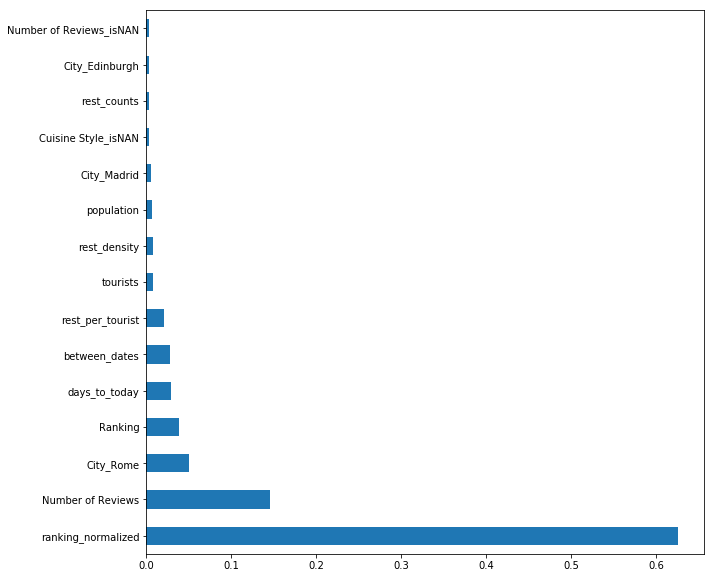

In [380]:
# using RandomForestRegressor to check the most important features for the model
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# 6. Submission

In [381]:
test_data.sample(10)

,Ranking,Number of Reviews,Rating,rest_counts,Number of Reviews_isNAN,Cuisine Style_isNAN,Price Range_isNAN,Reviews_isNAN,ranking_normalized,population,...,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,Price Range NAN,between_dates,days_to_today
5014,763.0,73.0,0.0,1647,0,0,0,0,-1.031446,547733,...,0,0,0,0,0,0,0,False,192,1152
7390,1296.0,12.0,0.0,590,0,0,0,0,1.422085,196150,...,0,0,0,0,0,0,0,False,0,4781
6806,5929.0,0.0,0.0,3813,1,1,1,0,0.609451,3155360,...,0,0,0,0,0,0,0,True,0,4781
458,2571.0,13.0,0.0,1145,0,1,1,0,1.491304,1364920,...,0,0,0,0,0,0,0,True,734,1200
2056,13813.0,57.0,0.0,7193,0,0,0,0,1.194610,8173900,...,0,0,0,0,0,0,0,False,15,1155
7550,5606.0,114.0,0.0,6108,0,0,0,0,-0.329846,2240621,...,0,0,0,0,0,0,0,False,244,1186
759,4914.0,8.0,0.0,2589,0,1,1,0,1.131781,2870493,...,0,1,0,0,0,0,0,True,3323,1458
5670,803.0,369.0,0.0,6108,0,0,0,0,-1.518728,2240621,...,0,0,0,0,0,0,0,False,9,1172
3677,9108.0,0.0,0.0,7193,1,1,1,0,0.198624,8173900,...,0,0,0,0,0,0,0,True,2806,1975
5213,1880.0,37.0,0.0,3813,0,1,1,0,-0.992428,3155360,...,0,0,0,0,0,0,0,True,3142,1639


In [382]:
test_data = test_data.drop(['Rating'], axis=1)

In [383]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [384]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [385]:
predict_submission

array([3.1  , 4.225, 4.405, ..., 3.02 , 4.46 , 4.37 ])

In [386]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.100
1,id_1,4.225
2,id_2,4.405
3,id_3,4.255
4,id_4,4.445
5,id_5,4.395
6,id_6,1.375
7,id_7,2.695
8,id_8,4.145
9,id_9,4.685
